<a href="https://colab.research.google.com/github/lechemrc/DS-Unit-2-Applied-Modeling/blob/master/module1/assignment_applied_modeling_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 1

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Choose which observations you will use to train, validate, and test your model. And which observations, if any, to exclude.
- [ ] Determine whether your problem is regression or classification.
- [ ] Choose your evaluation metric.
- [ ] Begin with baselines: majority class baseline for classification, or mean baseline for regression, with your metric of choice.
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" information from the future?

## Reading

### ROC AUC
- [Machine Learning Meets Economics](http://blog.mldb.ai/blog/posts/2016/01/ml-meets-economics/)
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)

### Imbalanced Classes
- [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)
- [Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/)

### Last lesson
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [How Shopify Capital Uses Quantile Regression To Help Merchants Succeed](https://engineering.shopify.com/blogs/engineering/how-shopify-uses-machine-learning-to-help-our-merchants-grow-their-business)
- [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)

### Colab Setup

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module1')

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), done.
From https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
Checking out files: 100% (26/26), done.
     |████████████████████████████████| 92kB 3.8MB/s 
     |████████████████████████████████| 112kB 10.8MB/s 
     |████████████████████████████████| 133kB 41.7MB/s 
     |████████████████████████████████| 57.7MB 329kB/s 
     |████████████████████████████████| 245kB 43.3MB/s 
     |████████████████████████████████| 614kB 45.2MB/s 
     |████████████████████████████████| 235kB 41.4MB/s 
     |████████████████████████████████| 307kB 47.4MB/s 
     |████████████████████████████████| 215kB 50.9MB/s 
     |████████████████████████████████| 51kB 25.4MB/s 
     |████████████████████████████████| 737kB 53.6MB

### Important Imports

In [0]:
# libraries and math functions
import pandas as pd
import numpy as np
import pandas_profiling
from scipy.io import arff # for loading .arff file
from scipy.stats import randint, uniform

# imports for pipeline and regression
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from ipywidgets import interact, fixed

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Importing dataset

Dataset has largely been cleaned previously 

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lechemrc/Datasets-to-ref/master/Autism%20Screening%20for%20Children/csv_result-Autism-Child-Data.csv', na_values='?')
print(df.shape)
df.head()

(292, 22)


,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,0,0,1,1,0,1,0,0,6.0,m,Others,no,no,Jordan,no,5,4-11 years,Parent,NO
1,2,1,1,0,0,1,1,0,1,0,0,6.0,m,Middle Eastern,no,no,Jordan,no,5,4-11 years,Parent,NO
2,3,1,1,0,0,0,1,1,1,0,0,6.0,m,NaN,no,no,Jordan,yes,5,4-11 years,NaN,NO
3,4,0,1,0,0,1,1,0,0,0,1,5.0,f,NaN,yes,no,Jordan,no,4,4-11 years,NaN,NO
4,5,1,1,1,1,1,1,1,1,1,1,5.0,m,Others,yes,no,United States,no,10,4-11 years,Parent,YES


### Data Wrangling

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/lechemrc/Datasets-to-ref/master/Autism%20Screening%20for%20Children/csv_result-Autism-Child-Data.csv', na_values='?')

def data_wrangle(df):
  ''' cleaning the data with one function'''

  # null values
  df = df.fillna(value='unspecified')

  # Dropping columns with single value
  df = df.drop('age_desc', axis=1)

  # Dropping id column to prevent obfuscation of data
  df = df.drop('id', axis=1)

  # Cleaning column names
  df = df.rename(columns={'jundice':'born_jaundice', 
                          'austim':'family_pdd', 
                          'contry_of_res':'country', 
                          'used_app_before':'prior_screening'})
  
  # Changing the country column values to 'other' if there are less
  # than 5 instances in the df
  frequencies = df['country'].value_counts()
  condition = frequencies <= 5
  mask = frequencies[condition].index
  mask_dict = dict.fromkeys(mask, 'other')

  df['country'] = df['country'].replace(mask_dict)

  # renaming values for clarity
  df['relation'] = df['relation'].replace(
      {'self':'Self', 
       'Health care professional':'Healthcare Professional', 
       'unspecified':'Unspecified'})
  
  df['ethnicity'] = df['ethnicity'].replace({'Pasifika':'Pacifica', 
                                           'Others':'unspecified'})

  return df

In [0]:
df = data_wrangle(df)

### Cleaning code used prior to data_wrangle function below

#### Null values

In [0]:
# df.isna().sum()

In [0]:
# df = df.fillna(value='unspecified')
# df.isna().sum()

In [0]:
# there's only one value in this column, so it will be dropped
# df['age_desc'].value_counts()

In [0]:
# df = df.drop('age_desc', axis=1)
# df.head()

#### Column renaming

In [0]:
# # renaming for clarity
# df = df.rename(columns={'jundice':'born_jaundice', 'austim':'family_pdd', 'contry_of_res':'country'})
# df.head()

#### country

In [0]:
# # Changing the country column values to 'other' if there are less
# # than 5 instances in the df

# frequencies = df['country'].value_counts()

# condition = frequencies <= 5
# mask = frequencies[condition].index
# mask_dict = dict.fromkeys(mask, 'other')

# df['country'] = df['country'].replace(mask_dict) 

# df['country'].value_counts()

#### relation

In [0]:
# # renaming values for clarity

# df['relation'] = df['relation'].replace({'self':'Self', 
#                                         'Health care professional':'Healthcare Prof', 
#                                         'unspecified':'Unspecified'})
# df['relation'].value_counts()

#### Ethnicity

In [0]:
# df['ethnicity'].value_counts()

In [0]:
# df['ethnicity'] = df['ethnicity'].replace({'Pasifika':'Pacifica', 
#                                            'Others':'unspecified'})

# df['ethnicity'].value_counts()

#### age

In [0]:
# # no need to change anything
# df['age'].value_counts()

#### gender

In [0]:
# # no need to change anything
# df['gender'].value_counts()

#### Class/ASD

In [0]:
# # no need to change anything
# df['Class/ASD'].value_counts()

### Preprocessing

In [0]:
# def simple_preprocess(df):
  
#   numeric = df.select_dtypes(include= "number").columns
#   categorical = df.select_dtypes(exclude = "number").columns
  
#   c_steps = [('c_imputer', SimpleImputer(strategy="most_frequent"))]
#   c_pipeline = Pipeline(c_steps)
  
#   n_steps = [('n_imputer', SimpleImputer())]
#   n_pipeline = Pipeline(n_steps)
  
#   df[numeric] = n_pipeline.fit_transform(df[numeric])
#   df[categorical] = c_pipeline.fit_transform(df[categorical])
  
#   return df

In [0]:
# simple_preprocess(df)

### Regression and Analysis

In [37]:
df['Class/ASD'].value_counts()

NO     151
YES    141
Name: Class/ASD, dtype: int64

In [40]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'born_jaundice', 'family_pdd', 'country',
       'prior_screening', 'result', 'relation', 'Class/ASD'],
      dtype='object')

In [46]:
# Result was giving the model 100% accuracy, 
# meaning there was major data leakage from it
df['result'].value_counts()

8     44
7     44
5     41
6     40
4     33
9     32
10    21
3     21
2      9
1      6
0      1
Name: result, dtype: int64

In [341]:
# Setting target and features
target = 'Class/ASD'

# Dropping 'result' and 'age' as they seem to be confounding and not helpful
features = df.columns.drop([target, 'result', 'age', 'family_pdd'])

X = df[features]
y = df[target]

# Train / Test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

# Train / Val split 
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, 
    stratify=y_trainval, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape 

((174, 16), (174,), (59, 16), (59,), (59, 16), (59,))

In [342]:
features

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'gender', 'ethnicity',
       'born_jaundice', 'country', 'prior_screening', 'relation'],
      dtype='object')

#### Majority Class Accuracy

In [0]:
pd.options.display.float_format = None

In [344]:
y_train.value_counts(normalize=True)

NO     0.517241
YES    0.482759
Name: Class/ASD, dtype: float64

In [345]:
# Accuracy score using the majority class
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred)

0.5084745762711864

#### XGBoost with ordinal encoder

In [0]:
# xgboost = make_pipeline(
#     ce.OrdinalEncoder(),
#     SimpleImputer(strategy='median')
# )

# X_train_processed = xgboost.fit_transform(X_train)
# X_val_processed = xgboost.transform(X_val)

# eval_set = [(X_train_processed, y_train), 
#             (X_val_processed, y_val)]

# model = XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42)
# model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
#           early_stopping_rounds=10)

# y_pred = model.predict(X_test)

#### Random Forest Classifier with ordinal encoder

In [0]:
# random_forest_ord = make_pipeline(
#     ce.OrdinalEncoder(),
#     SimpleImputer(strategy='median'),
#     RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# )

# random_forest_ord.fit(X_train, y_train)
# y_pred = random_forest_ord.predict(X_test)
# print('Validation Accuracy:', random_forest_ord.score(X_val, y_val))

The Random Forest Classifier with One Hot Encoder was the better model. XGBoost says it had a nearly 100% accuracy, but I'm very skeptical of that and figiure there's some overfitting happening. 

#### Random Forest Classifier with One Hot Encoding

In [348]:
random_forest = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print('Validation Accuracy:', random_forest.score(X_val, y_val), 
      '\nTest Accuracy:', random_forest.score(X_test, y_test))

Validation Accuracy: 0.8305084745762712 
Test Accuracy: 0.9322033898305084


### Confusion Matrix

In [0]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

In [350]:
unique_labels(y_val)

array(['NO', 'YES'], dtype='<U3')

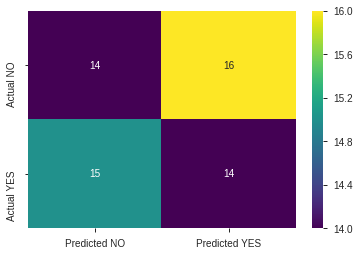

In [351]:
plot_confusion_matrix(y_val, y_pred);

In [352]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          NO       0.48      0.47      0.47        30
         YES       0.47      0.48      0.47        29

    accuracy                           0.47        59
   macro avg       0.47      0.47      0.47        59
weighted avg       0.47      0.47      0.47        59



### ROC Accuracy

In [353]:
y_pred = random_forest.predict(X_test)
accuracy_score(y_val, y_pred)

0.4745762711864407

In [354]:
y_pred_proba = random_forest.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.95

In [355]:
y_val.shape, y_pred_proba.shape

((59,), (59,))

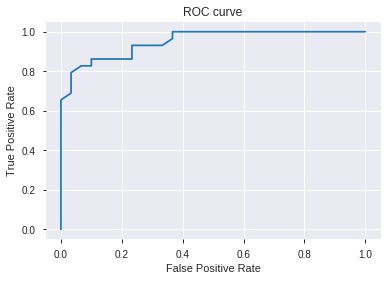

In [356]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val=='YES', y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [357]:
def set_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    For binary classification problems. 
    y_pred_proba : predicted probability of class 1
    """
    
    # Apply threshold to predicted probabilities
    # to get discrete predictions
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    # Plot distribution of predicted probabilities
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    # Calculate true positive rate and false positive rate
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Plot point on ROC curve for the current threshold
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    # Show ROC AUC score
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))
    
    # Show confusion matrix & classification report
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.05));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…